# Dataflow from calibration until ball visualization

This notebook explains how we get from detected ball positions to a 3D visualization of tennisball. For our example we use this video: https://www.youtube.com/watch?v=UEb1mg8mtSg. Before running the notebook video frames must be extracted.

In [1]:
# Import python packages
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import math
from sklearn import linear_model
from matplotlib import animation
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
# Import own modlues
from calibration import getCalibration
from get3Dposition import transform_params, get_3D_position, get_trajectory, get_time
from smoothballposition import ReadTFOutput, MaxDistBallPerFramePXL, smoothball, PlotSmoothVsNotSoSmooth
from criticalPoints import regression, angular, genFeatures

# 0. Load data

In [3]:
# Set parameters
KerberHalep = True

In [4]:
# Load example image and calibration manually defined points
if KerberHalep:
    imgpath = os.path.join(os.getcwd(), '../images/3_image_GP_00306.png')
    image = plt.imread(imgpath)
    PathToCaliPoints = 'Kalibrierung_KerbHal_planar.txt'
    ballpostf = '../ballpositions.csv'
    framerate = 25
    maxballspeed = 200
else:
    image = cv2.imread('../images/image_GP_00001.png')
    PathToCaliPoints = 'Kalibrierung_planar.txt'

# 1. Camera calibration

In [5]:
ret, M, D, R, T, imgpoints, objpoints, newM, roi = getCalibration(PathToCaliPoints=PathToCaliPoints, image_width=image.shape[1], image_height=image.shape[0])
print('RMS re-projection error:', ret)

RMS re-projection error: 0.44133126685116225


In [6]:
R,T,F = transform_params(R=R,T=T)
print('Camera matrix: \n', M, '\n')
print('Rotation matrix: \n', R, '\n')
print('Translation matrix: \n', T, '\n')
print('Distortion coefficients: \n' ,D,'\n')

Camera matrix: 
 [[  3.06829009e+03   0.00000000e+00   1.03076382e+03]
 [  0.00000000e+00   1.84903970e+03   7.95185369e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 

Rotation matrix: 
 [[ 0.99967073 -0.02039793  0.01556773]
 [ 0.00236265 -0.53094778 -0.84740124]
 [ 0.02555088  0.847159   -0.53072477]] 

Translation matrix: 
 [ -6.08382279   0.39552413  25.17820774] 

Distortion coefficients: 
 [  7.03608304e-01  -1.32710776e+01   2.41858300e-02   1.53166252e-02
   8.44309136e+01] 



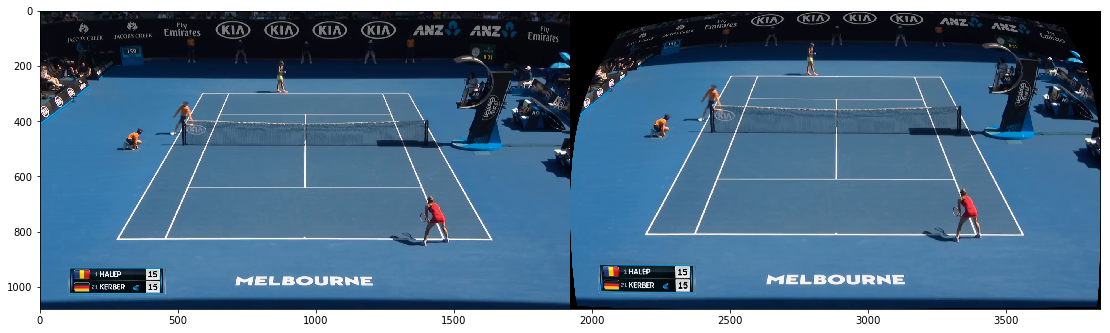

In [7]:
# Plot distorted vs undistorted image
dst = cv2.undistort(image, M, D, None, newM)
images = np.hstack((image, dst))
plt.figure(figsize=(19,8))
plt.imshow(images)
plt.show()

# 2. Smooting time series with outlier detection

In [8]:
# Load detected ball position into array
ballpos = ReadTFOutput(ballpostf, image)
print('Tensorflow output [imagenumber, x, y, accuracy] :\n', ballpos[0:3])

Tensorflow output [imagenumber, x, y, accuracy] :
 [[  0.00000000e+00   1.13646733e+03   4.17806878e+02   5.48318000e-03]
 [  1.00000000e+00   1.37297530e+03   4.51113743e+02   3.28167000e-03]
 [  2.00000000e+00   1.05015210e+03   4.66790499e+02   1.65076700e-02]]


### Outlier detection
Even though we set an accuracy lower bound, there can still be outliier in the ball positions (see above)
Therefore we check if the ballposition is within a reachable distance. Ball speed is set to maximum speed ever reached in tennis (263 km/ h).

In [9]:
mdist_pxl = MaxDistBallPerFramePXL(framerate, outleftnet_pxl=[535,1270], 
                                   outrightnet_pxl=[640, 374], maxspeed_km_h=maxballspeed)

Maximum distance of ball within one frame (x, y, both) 106.56630999 38.5668550439 113.330405156


### Smoothing: Example smoothed points (red) vs. original points (blue)
The smoothball function uses the maximum distance a ball can move from one frame to the next one and the threshold for detection accuracy. The threshold can be low, since we expect a ball on almost every frame of the video.

In [10]:
smballpos = smoothball(ballpos, ThesBallDetection=0.2, mdist_pxl=mdist_pxl)

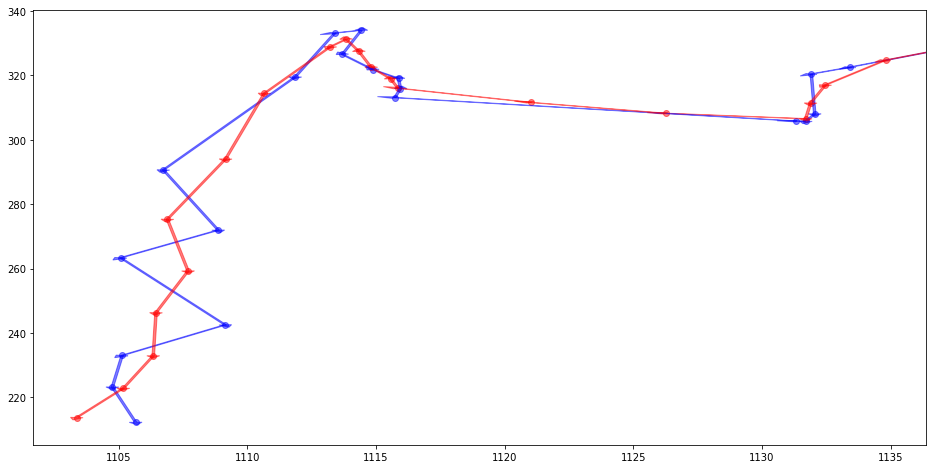

In [11]:
startframe=500
seqlength=20

plt.figure(figsize=(16,8))

oldrow = ballpos[startframe - 1]
oldsmpos = ballpos[startframe - 1]

for i, row in enumerate(ballpos[startframe:startframe+seqlength]):
    plt.scatter(row[1], row[2], c='b', alpha=.5)
    plt.arrow(oldrow[1], oldrow[2], row[1] - oldrow[1], row[2] - oldrow[2],
              width=0.1, head_width=0.5, color='b', alpha=0.5)
    oldrow = row.copy()

    # Check if detected frame is part of smoothed values
    val = np.where(smballpos[:, 0] == row[0])
    if len(val[0]) > 0:
        plt.scatter(smballpos[int(val[0]), 1], smballpos[int(val[0]), 2], c='r', alpha=0.5)
        plt.arrow(oldsmpos[1], oldsmpos[2], smballpos[int(val[0]), 1] - oldsmpos[1],
                  smballpos[int(val[0]), 2] - oldsmpos[2],
                  width=0.1, head_width=0.5, color='r', alpha=0.5)
        oldsmpos = smballpos[int(val[0])].copy()
plt.show()

# 3. Model for bounce and hit detection

### Generate features

In [12]:
# Number of points used for regression
nump = 3
# Because of smoothing edges disappear. Jump can be used to leave points out
jump = 1
bouncehitfeatures = genFeatures(smpos=smballpos, nump=nump, jump=jump)

##### Example for generated features

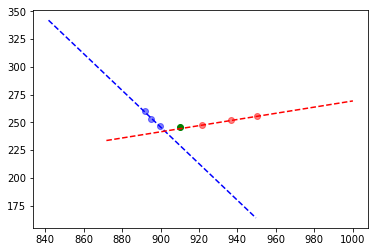

Points define regression line: 
 [1, -1.6476915147948763] [1, 0.27760824935585465] 

Output to bouncehitfeatures: 
 Feature vector [imagename, angle, error of each regression (sc1, sc2) 
 sum of direction vectors (r1x, r1y, r2x, r2y) 
 3_image_GP_01442.png 74.26112235665178 0.975833483934 0.999986106551 12.4610368 -18.9818046 43.4031008 12.0728556


In [13]:
cpregtest = []
for i in range(startframe,startframe+1):
    
    imgname = '3_image_GP_'+str(int(smballpos[i,0])).zfill(5)+ '.png'
    
    # Calculate regression through nump number of points
    slo1, int1, sc1 = regression(smballpos[i-jump-nump+1:i-jump+1, 1:3])
    slo2, int2, sc2 = regression(smballpos[i+jump:i+jump+nump, 1:3])
            
    # Check orientation, since slope must be negativ if x and y < 0
    x1, x2 = 1, 1
    r1 = sum(smballpos[i-jump, 1:3] - smballpos[i-jump-nump+1:i-jump+1, 1:3])
    r2 = sum(smballpos[i+jump:i+jump+nump, 1:3] - smballpos[i+jump, 1:3])
    if (r1[0] < 0 and r1[1] < 0) or (r1[0] < 0 and r1[1] > 0):
        slo1[0, 0] *= -1
        x1 = -1
    if (r2[0] < 0 and r2[1] < 0) or (r2[0] < 0 and r2[1] > 0):
        slo2[0, 0] *= -1
        x2 = -1
        
    #calculate angle if except lines are parallel
    alpha = angular([x1,slo1[0,0]], [x2,slo2[0,0]])

    # Generate plot
    plt.plot(smballpos[i-jump-nump+1:i-jump+1, 1], smballpos[i-jump-nump+1:i-jump+1, 2], 'bo', alpha=0.5)
    plt.plot(smballpos[i+jump:i+jump+nump, 1], smballpos[i+jump:i+jump+nump, 2], 'ro', alpha=0.5)
    plt.plot(smballpos[i, 1], smballpos[i, 2], 'go')
    a = np.linspace(np.min(smballpos[i-jump-nump+1:i-jump+1, 1])-50, 
                    np.max(smballpos[i-jump-nump+1:i-jump+1, 1])+50, 50)
    b = [val*slo1[0,0]+int1 for val in a]
    plt.plot(a, b, 'b--')
    c = np.linspace(np.min(smballpos[i+jump:i+jump+nump, 1])-50, 
                    np.max(smballpos[i+jump:i+jump+nump, 1])+50, 50)
    d = [val*slo2[0,0]+int2 for val in c]
    plt.plot(c, d, 'r--')
    plt.show()
    
    print('Points define regression line: \n', [x1,slo1[0,0]], [x2,slo2[0,0]], '\n')
    print('Output to bouncehitfeatures: \n',
          'Feature vector [imagename, angle, error of each regression (sc1, sc2)',
          '\n', 'sum of direction vectors (r1x, r1y, r2x, r2y) \n',
          imgname, alpha, sc1, sc2, r1[0], r1[1], r2[0], r2[1]
         )

In [14]:
# Transform in pandas dataframe prepare it and add more features
bouncehitfeatures = pd.DataFrame(bouncehitfeatures)
bouncehitfeatures[[1,2,3,4,5,6,7]] = bouncehitfeatures[[1,2,3,4,5,6,7]].apply(pd.to_numeric)
bouncehitfeatures = bouncehitfeatures.set_index(0)
bouncehitfeatures.columns = ['angle', 'sc1', 'sc2', 'r1_x', 'r1_y', 'r2_x', 'r2_y']
bouncehitfeatures['sum_sc'] = bouncehitfeatures['sc1']+bouncehitfeatures['sc2']
bouncehitfeatures.head()

,angle,sc1,sc2,r1_x,r1_y,r2_x,r2_y,sum_sc
0,,,,,,,,
3_image_GP_00396.png,113.363850,0.110322,0.997281,-172.095155,-245.547203,82.872490,142.796196,1.107603
3_image_GP_00400.png,8.913625,0.989273,0.998334,-244.194806,-386.477546,50.667066,97.637474,1.987606
3_image_GP_00401.png,7.101973,0.998514,0.993830,-235.420496,-401.107693,56.522128,111.591684,1.992344
3_image_GP_00402.png,8.962912,1.000000,0.999274,-199.163693,-352.111439,63.474960,152.478072,1.999274
3_image_GP_00403.png,8.678114,0.997281,0.999898,-183.757968,-365.085220,61.146995,158.356717,1.997179


### Load labels

In [15]:
# Load labeled data
hitservedata = []
with open('../annotations/BounceHit.txt', 'r') as f:
    for row in f:
        num, label = row.strip('\n').split(' ')[0:2]
        hitservedata += [num, label]
hitservedata = np.array(hitservedata).reshape(-1,2)
hitservedata[0:2]

array([['3_image_GP_00397.png', 'Hit'],
       ['3_image_GP_00411.png', 'Bounce']], 
      dtype='<U20')

In [16]:
# Same for testdata
hitservedata = pd.DataFrame(hitservedata)
hitservedata = hitservedata.set_index(0)
hitservedata.columns = ['label']

### Prepare training and testset

In [17]:
# Join hitservedata with features
hitservedata = hitservedata.join(bouncehitfeatures, how='inner')

In [18]:
# Split into training and testset
train, test = train_test_split(hitservedata)

In [19]:
train.head()

,label,angle,sc1,sc2,r1_x,r1_y,r2_x,r2_y,sum_sc
0,,,,,,,,,
3_image_GP_03359.png,Nothing,16.687257,0.292412,0.996086,-895.115187,-863.932907,418.903520,353.428272,1.288498
3_image_GP_03433.png,Nothing,133.926914,0.894263,0.944830,22.236675,-187.202435,126.251722,-59.031338,1.839094
3_image_GP_00442.png,Bounce,56.466538,0.280726,0.486960,144.893507,170.095306,-32.541792,-99.407839,0.767685
3_image_GP_03450.png,Nothing,8.735278,0.999839,0.999986,-203.213229,204.927615,62.920621,-54.297301,1.999825
3_image_GP_03449.png,Nothing,7.489002,0.999683,0.999998,-220.994986,243.363368,63.951152,-54.790808,1.999682


### Visualize features and labels


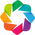

In [20]:
# Import bokeh for data exploration
import holoviews as hv
hv.extension('bokeh')

In [21]:
%%opts Scatter [width=800 height=400 scaling_method='width' scaling_factor=0.1 size_index=2 show_grid=True] 
%%opts Scatter (color=Cycle('Category20') line_color='k' size=10)
%%opts NdOverlay [legend_position='left' show_frame=False]

data = hv.Table(train, ['label','sum_sc'] ,['angle','sc1', 'sc2', 'r1_x','r2_x','r2_y', 'r1_y'])
scatter = data.to.scatter('sum_sc', ['angle', 'r2_x'])
scatter.overlay('label')

:NdOverlay   [label]
   :Scatter   [sum_sc]   (angle,r2_x)

In [22]:
%%opts Scatter [width=800 height=400 scaling_method='width' scaling_factor=0.1 size_index=2 show_grid=True] 
%%opts Scatter (color=Cycle('Category20') line_color='k' size=10)
%%opts NdOverlay [legend_position='left' show_frame=False]

data1 = hv.Table(train, ['label','r2_y'] ,['angle','sc1', 'sc2', 'r1_x','r2_x','r2_y', 'r1_y'])
scatter = data1.to.scatter('r2_y', ['r1_y', 'r1_x'])
scatter.overlay('label')

:NdOverlay   [label]
   :Scatter   [r2_y]   (r1_y,r1_x)

### Train model

In [23]:
features = ['angle','sc1','sc2','r1_x','r1_y','r2_x','r2_y','sum_sc']

clf = RandomForestClassifier(n_estimators=30, max_depth=20, max_features=8, random_state=0, 
                             class_weight='balanced')
cross_val_score(clf, train[features], train['label'], cv=None)
clf.fit(train[features], train['label'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features=8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [24]:
clf.feature_importances_

array([ 0.24010025,  0.05731662,  0.07942778,  0.07967399,  0.08429957,
        0.21080112,  0.0917684 ,  0.15661228])

Especially angle is a important feature to predict if frame was either bounce hit or none of it

### Evaluate model

In [25]:
train['label'].value_counts()

Nothing    55
Bounce     22
Hit        16
Name: label, dtype: int64

In [26]:
print('    ', 'Bounce', 'Hit', 'Nothing')
confusion_matrix(test['label'], clf.predict(test[features]))

     Bounce Hit Nothing


array([[ 2,  1,  4],
       [ 0,  3,  0],
       [ 0,  1, 20]])

We can see that Bounces are in half the cases of the testset not detected

In [27]:
clf.score(test[features], test['label'])

0.80645161290322576

Here we need to consider an other measure, since detecting the correct frame is very difficult. Since the ball moves very fast there is often no specifc frame, but two contributing frames. A better measure would not only consider one frame, but a within two/three frame range.

### Visualize detections

In [28]:
cpreg = clf.predict(bouncehitfeatures[features])

In [29]:
bouncehitfeatures['prediction'] = cpreg

In [30]:
print('Less predictions since features of first and last ballpositions can not be calulated: \n',
      'length ballposition: ', len(smballpos), '\n',
      'length predictions: ', len(cpreg))

Less predictions since features of first and last ballpositions can not be calulated: 
 length ballposition:  9904 
 length predictions:  9896


Because of this cpreg[k-jump-nump] belongs to smballpos[k]

<IPython.core.display.Javascript object>


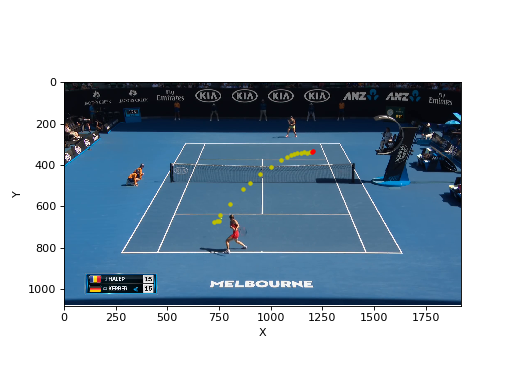

In [31]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
plt.imshow(image)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
scatter, = ax.plot([], [], 'b.')
cmap = ['y', 'r', 'g', 'b']

scatter = [ax.imshow(image)]
for c in cmap:
    scatter.append(ax.plot([], [], '.', color=c))

def init():
    for scat in scatter[1:]:
        print(scat[0])
        scat[0].set_data([],[])
    scatter[0].set_data(image)
    return scatter

def pltpos(i):
    i += 390
    npoi = 20
    # If frames were extracted they can be plotted, otherwise example image is used as background image
    try:
        imgpath = os.path.join(os.getcwd(), '../../Videos/GoPro/GoProFrames/3_image_GP_' + 
                               str(int(ballpos[i,0])).zfill(5) +'.png')
        img = plt.imread(imgpath)
    except FileNotFoundError:
        img = image
    
    # Check if detection is in smoothed positions
    j = np.where(smballpos[:,0] == int(ballpos[i,0]))
    if len(j[0]) > 0:
        vals = [k+int(j[0]) for k,x in enumerate(smballpos[int(j[0]):int(j[0])+npoi, 3])]
        ball = [k for k in vals if cpreg[k-jump-nump] == 'Nothing']
        hit = [k for k in vals if cpreg[k-jump-nump] == 'Hit']
        bounce = [k for k in vals if cpreg[k-jump-nump] == 'Bounce']
        pink = [k for k in vals if cpreg[k-jump-nump] == 3]
        x = smballpos[ball,1]
        y = smballpos[ball,2]
        x1 = smballpos[hit, 1]
        y1 = smballpos[hit, 2]
        x2 = smballpos[bounce, 1]
        y2 = smballpos[bounce, 2]
        x3 = smballpos[pink, 1]
        y3 = smballpos[pink, 2]
        xlist = [x, x1, x2, x3]
        ylist = [y, y1, y2, y3]
        
        for lnum, scat in enumerate(scatter[1:]):
            scat[0].set_data(xlist[lnum], ylist[lnum])
        
    # If not, plot previous points
    else:
        for lnum, scat in enumerate(scatter[1:]):
            scat[0].set_data(xlist[lnum], ylist[lnum])
    scatter[0].set_data(img)

    return scatter



ani = animation.FuncAnimation(fig, pltpos, init_func=init, frames=20000, interval=200, blit=True)
plt.gca().invert_yaxis()
plt.show()

# 4. From image points to world points

### Calculate 3D position

To reconstruct a scene from an image the matrix of camera calibration process are used.
If either one X, Y or Z of 3D position is known we can calculate the real world point. If not two points defining the real world ray are calculated. The example shows calculation of world point / ray for (280, 825) which is the outer, left, nearby edge of the court. This edge was defined origin of world coordinate system (0,0,0)


In [32]:
point = get_3D_position(imgpoint=[280, 825], R=R, M=M, T=T, F=F, objpoint={'X':None, 'Y':None, 'Z':0})
ray1 = get_3D_position(imgpoint=[280, 825], R=R, M=M, T=T, F=F, objpoint={'X':None, 'Y':None, 'Z':1}, point=False)
ray2 = get_3D_position(imgpoint=[280, 825], R=R, M=M, T=T, F=F, objpoint={'X':None, 'Y':None, 'Z':None}, point=False)

In [33]:
print('3D Point for Z = 0: \n', point, '\n')
print('3D ray if X,Y are unknown, Z=0 known: \n', ray1, '\n')
print('3D ray if X,Y,Z are unknown: \n', ray2, '\n')

3D Point for Z = 0: 
 [ -7.28316103e-02  -1.94655695e-02  -1.05471187e-15] 

3D ray if X,Y are unknown, Z=0 known: 
 (array([ 0.326687  , -1.55830592,  1.        ]), array([ 1.05725544, -4.37226293,  2.82862181])) 

3D ray if X,Y,Z are unknown: 
 (array([ -7.28316103e-02,  -1.94655695e-02,  -1.05471187e-15]), array([ 1.05725544, -4.37226293,  2.82862181])) 



### Calculate 3D trajectory

For a given start and endpoint of the ballcurve we can calculate the ball position on the trajectoy. Since accuracy of bounce and hit detection is not high enough we select a hit and bounce manually for visualization. We assume a hit takes place at 1m height (serves not included).

In [34]:
# Manually select ball positions
a = np.where(smballpos[:, 0] == ballpos[665][0])[0][0]
b = np.where(smballpos[:, 0] == ballpos[686][0])[0][0]
trajectory2D = ballpos[a:b]

In [35]:
trajectory3D = np.around(get_trajectory(trajectory2D, R=R, M=M, T=T, F=F), 2)
time3D = get_time(trajectory2D)

[ 6.54730767  5.12059591  1.        ] [  6.88859353e+00   8.57538088e+00   1.33226763e-15]
[ 6.39298417  8.71293796  1.        ] [ 6.03113717 -2.63263976  5.84492062]
[ 6.34734181  7.18038662  1.        ] [ 6.02655663 -2.84194134  5.51060656]
[ 6.02147808  6.84442853  1.        ] [ 5.81920999 -2.88535765  5.43132176]
[ 6.65831001  6.51008853  1.        ] [ 6.24246712 -2.94422576  5.35773173]
[ 6.87403191  5.38727573  1.        ] [ 6.41518397 -3.11948425  5.08629396]
[ 6.38802388  8.35336665  1.        ] [ 6.03369873 -2.68030048  5.76896647]
[ 6.30377226  7.11414525  1.        ] [ 5.99939034 -2.85075172  5.49523528]
[ 6.31615869  6.9209826   1.        ] [ 6.01045868 -2.8787644   5.45105346]
[ 6.28564429  6.72062436  1.        ] [ 5.99365295 -2.90747151  5.40442121]
[ 6.83177125  5.95996375  1.        ] [ 6.37104564 -3.0297633   5.2273843 ]
[ 6.95331927  7.31094903  1.        ] [ 6.4148801  -2.83256246  5.54427262]
[ 6.610322    6.98706904  1.        ] [ 6.20069076 -2.87370512  5.4682876

In [36]:
# Save results
# np.savetxt('../results/trajectory3Dexample.txt', np.around(trajectory3D,2))

### Visualize trajectory